In [41]:
from dataset import SchoolingDataset, HappinessDataset
import logging

In [42]:
# logging configuration
logging.basicConfig(
    level=logging.INFO,
    format="%(name)s:%(lineno)s [%(levelname)s]: %(message)s",
)

In [43]:
SCHOOLING_DATA = SchoolingDataset.from_kaggle()
HAPPY_DATA = HappinessDataset.from_kaggle()

dataset:73 [INFO]: Loaded data for years: ['2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']


In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Set up visualization style
sns.set_theme(style="whitegrid")

# Preprocess and Merge Datasets
# Convert SCHOOLING_DATA to long format for easier merging with HAPPY_DATA
schooling_data_long = SCHOOLING_DATA._data.melt(
    id_vars=['ISO3', 'Country', 'Continent', 'Hemisphere', 
             'Human Development Groups', 'UNDP Developing Regions', 'HDI Rank (2021)'],
    var_name='Year', value_name='Expected Years of Schooling'
)

# Extract year from column names
schooling_data_long['Year'] = schooling_data_long['Year'].str.extract(r'(\d{4})').astype(int)

# Initialize a dictionary to store merged data by year
merged_data = {}
for year in HAPPY_DATA._data.keys():
    happiness_data_year = HAPPY_DATA._data[year]
    happiness_data_year['Year'] = int(year)
    merged = pd.merge(
        happiness_data_year, schooling_data_long, 
        left_on=['country', 'Year'], right_on=['Country', 'Year'],
        how='inner'
    )
    merged_data[year] = merged

# Concatenate all years into a single DataFrame for easier visualization
all_data = pd.concat(merged_data.values(), ignore_index=True)



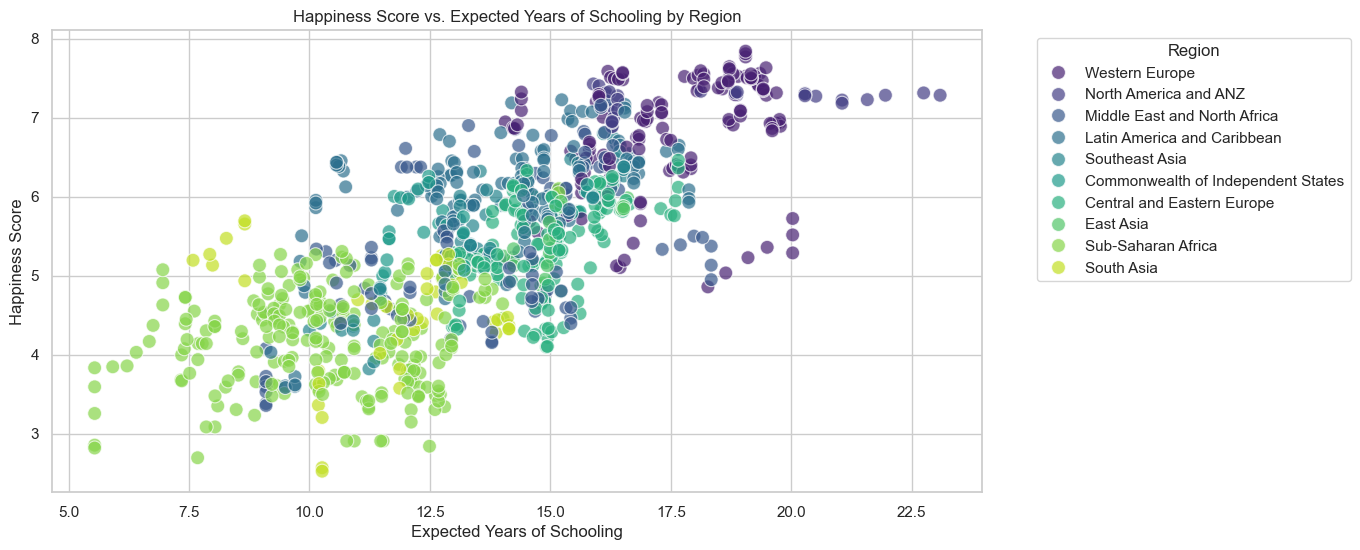

In [45]:
# 1. Scatter Plot: Happiness Score vs. Expected Years of Schooling by Region
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=all_data,
    x="Expected Years of Schooling",
    y="happiness_score",
    hue="region",  # Assuming region is a column in the dataset
    palette="viridis",
    s=100,  # Bubble size
    edgecolor="w",
    alpha=0.7
)
plt.title("Happiness Score vs. Expected Years of Schooling by Region")
plt.xlabel("Expected Years of Schooling")
plt.ylabel("Happiness Score")
plt.legend(title="Region", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

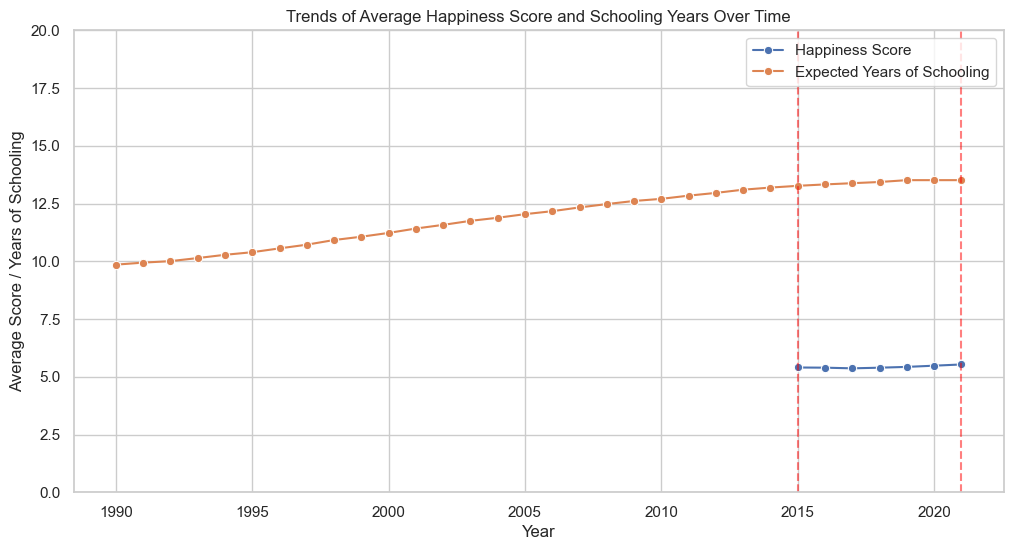

In [46]:
# 2. Line Plot: Average Happiness Score and Schooling Years Over Time
plt.figure(figsize=(12, 6))
# Calculate yearly averages
avg_data_happy = all_data.groupby("Year").mean('happiness_score').reset_index()
avg_data_schooling = schooling_data_long.groupby("Year").mean('Expected Years of Schooling').reset_index()
sns.lineplot(data=avg_data_happy, x="Year", y="happiness_score", label="Happiness Score", marker="o")
sns.lineplot(data=avg_data_schooling, x="Year", y="Expected Years of Schooling", label="Expected Years of Schooling", marker="o")
plt.vlines(avg_data_happy["Year"].min(), 0, 20, linestyles="dashed", alpha=0.5, color="red")
plt.vlines(avg_data_happy["Year"].max(), 0, 20, linestyles="dashed", alpha=0.5, color="red")
plt.title("Trends of Average Happiness Score and Schooling Years Over Time")
plt.ylabel("Average Score / Years of Schooling")
plt.xlabel("Year")
plt.ylim(0, 20)
plt.legend()
plt.show()

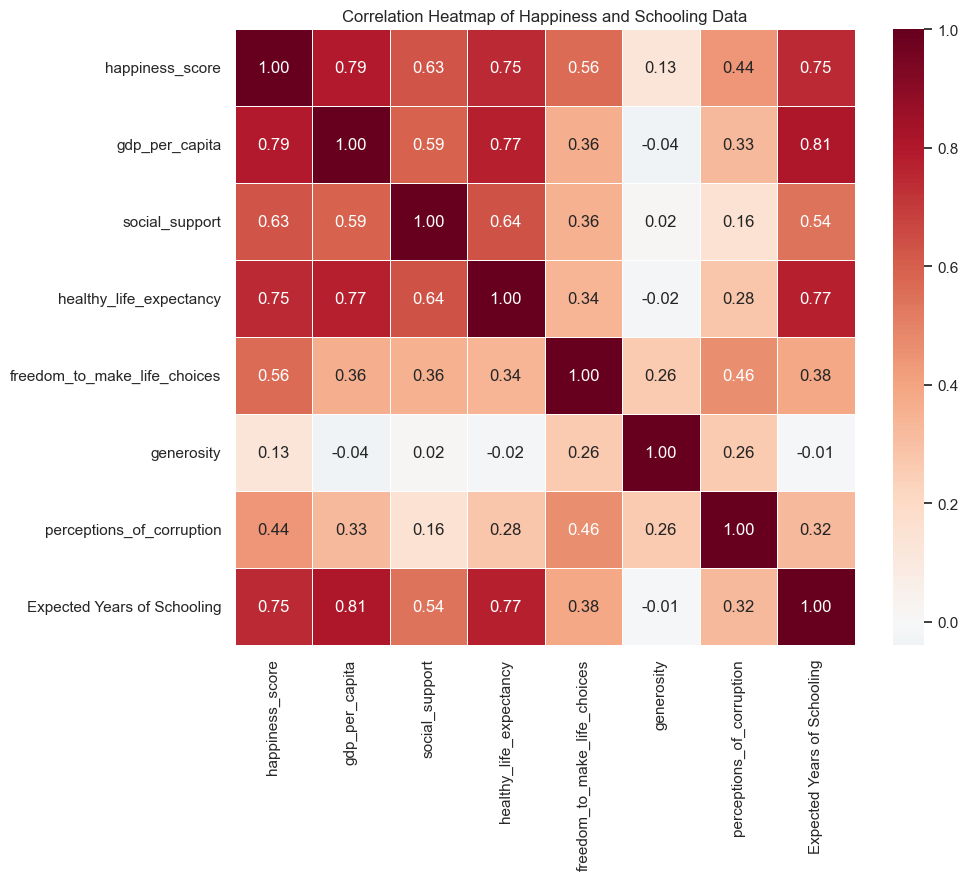

In [47]:
# 3. Heatmap of Correlations between Happiness Factors and Schooling
correlation_data = all_data[['happiness_score', 'gdp_per_capita', 'social_support', 
                             'healthy_life_expectancy', 'freedom_to_make_life_choices', 
                             'generosity', 'perceptions_of_corruption', 
                             'Expected Years of Schooling']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    data=correlation_data,
    annot=True,
    cmap="RdBu_r",  # Use a diverging color map for better contrast
    center=0,
    linewidths=0.5,
    fmt=".2f"  # Limit decimal places to improve readability
)
plt.title("Correlation Heatmap of Happiness and Schooling Data")
plt.show()


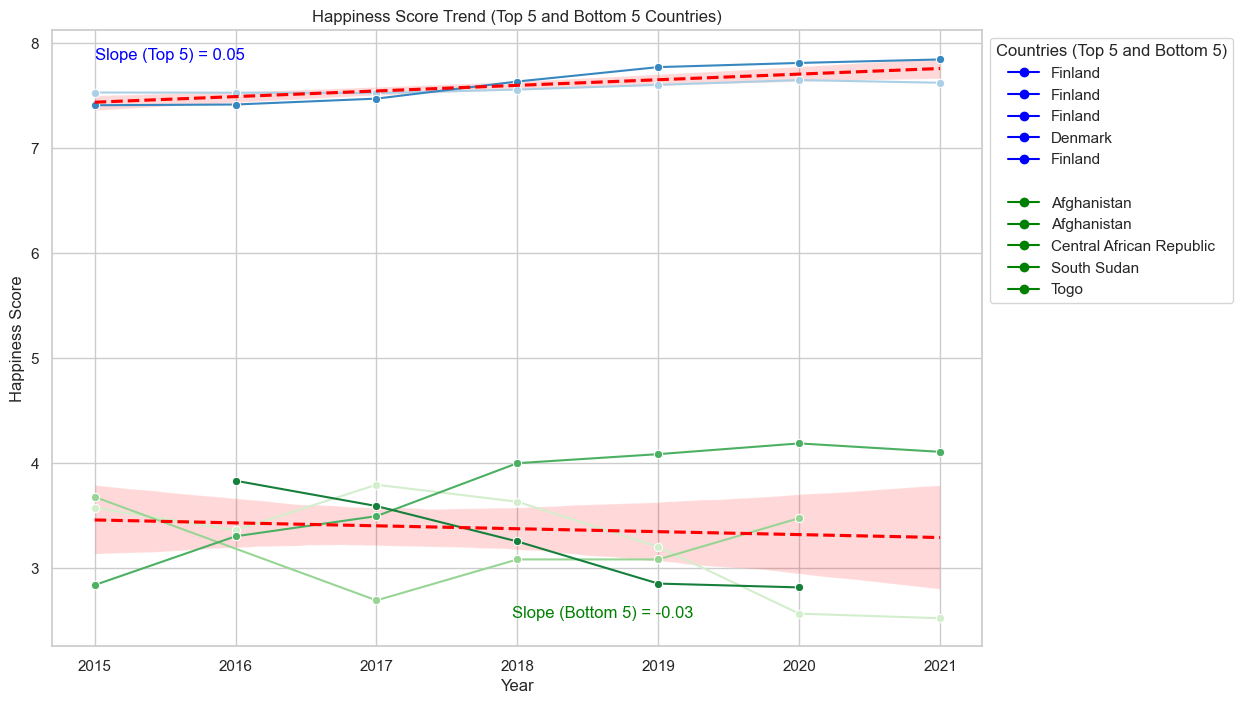

In [48]:
# Since we need to calculate and display the slopes of each regression line, we'll compute the linear regression manually and annotate the plot with the slopes.

import numpy as np
from scipy.stats import linregress

avg_happiness_per_year_country = all_data.groupby(['Year', 'country']).mean(numeric_only=True).reset_index()
top_5_countries = avg_happiness_per_year_country.nlargest(5, 'happiness_score')['country']
bottom_5_countries = avg_happiness_per_year_country.nsmallest(5, 'happiness_score')['country']

top_5_data = avg_happiness_per_year_country[avg_happiness_per_year_country['country'].isin(top_5_countries)]
bottom_5_data = avg_happiness_per_year_country[avg_happiness_per_year_country['country'].isin(bottom_5_countries)]

# Calculate slope for top 5 countries
slope_top, intercept_top, _, _, _ = linregress(top_5_data['Year'], top_5_data['happiness_score'])

# Calculate slope for bottom 5 countries
slope_bottom, intercept_bottom, _, _, _ = linregress(bottom_5_data['Year'], bottom_5_data['happiness_score'])

# Plotting the line chart
plt.figure(figsize=(12, 8))

# Top 5 countries plot
sns.lineplot(x='Year', y='happiness_score', hue='country', data=top_5_data, palette='Blues', marker='o', legend=False)
# Bottom 5 countries plot
sns.lineplot(x='Year', y='happiness_score', hue='country', data=bottom_5_data, palette='Greens', marker='o', legend=False)

# Adding linear regression lines for trend (one for each group)
sns.regplot(x='Year', y='happiness_score', data=top_5_data, scatter=False, color='red', line_kws={'linestyle': '--'})
sns.regplot(x='Year', y='happiness_score', data=bottom_5_data, scatter=False, color='red', line_kws={'linestyle': '--'})

# Annotate slopes on the plot
plt.text(top_5_data['Year'].min(), top_5_data['happiness_score'].max(), f'Slope (Top 5) = {slope_top:.2f}', color='blue', fontsize=12)
plt.text(bottom_5_data['Year'].mean(), bottom_5_data['happiness_score'].min(), f'Slope (Bottom 5) = {slope_bottom:.2f}', color='green', fontsize=12)

# Custom legend
legend_elements = []

# Add top countries to legend
legend_elements.extend([plt.Line2D([0], [0], color='blue', marker='o', linestyle='-', label=country) for country in top_5_countries])
# Add a gap
legend_elements.append(plt.Line2D([0], [0], color='white', label=''))
# Add bottom countries to legend
legend_elements.extend([plt.Line2D([0], [0], color='green', marker='o', linestyle='-', label=country) for country in bottom_5_countries])

# Display the custom legend
plt.legend(handles=legend_elements, title='Countries (Top 5 and Bottom 5)', loc='upper left', bbox_to_anchor=(1, 1))

# Set title and labels
plt.title('Happiness Score Trend (Top 5 and Bottom 5 Countries)')
plt.xlabel('Year')
plt.ylabel('Happiness Score')

# Display the plot
plt.show()





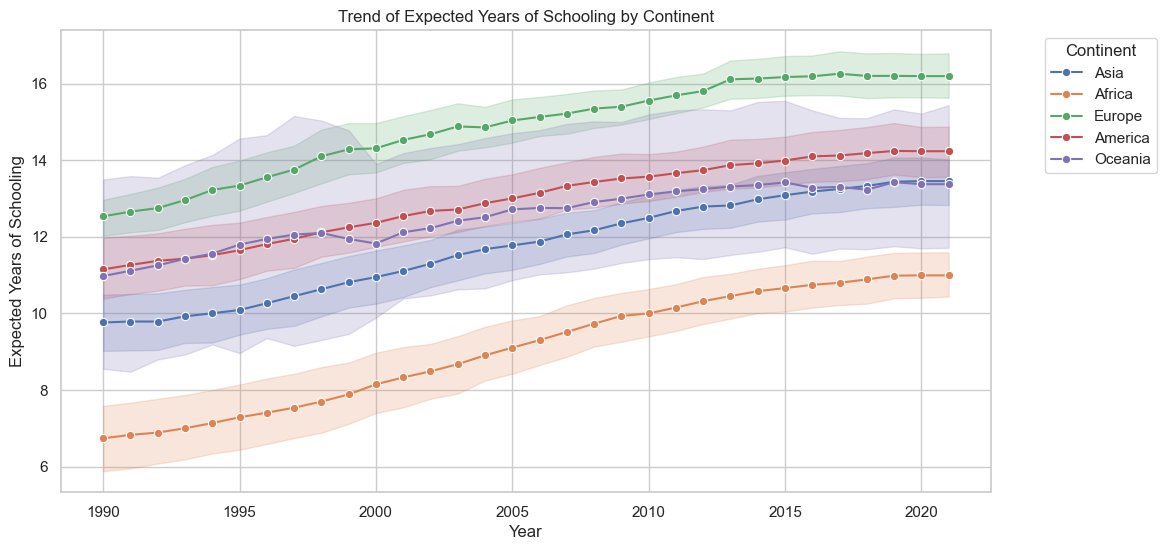

In [49]:
# Trend Analysis of Expected Years of Schooling by Continent
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=schooling_data_long,
    x="Year",
    y="Expected Years of Schooling",
    hue="Continent",
    marker="o"
)
plt.title("Trend of Expected Years of Schooling by Continent")
plt.xlabel("Year")
plt.ylabel("Expected Years of Schooling")
plt.legend(title="Continent", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

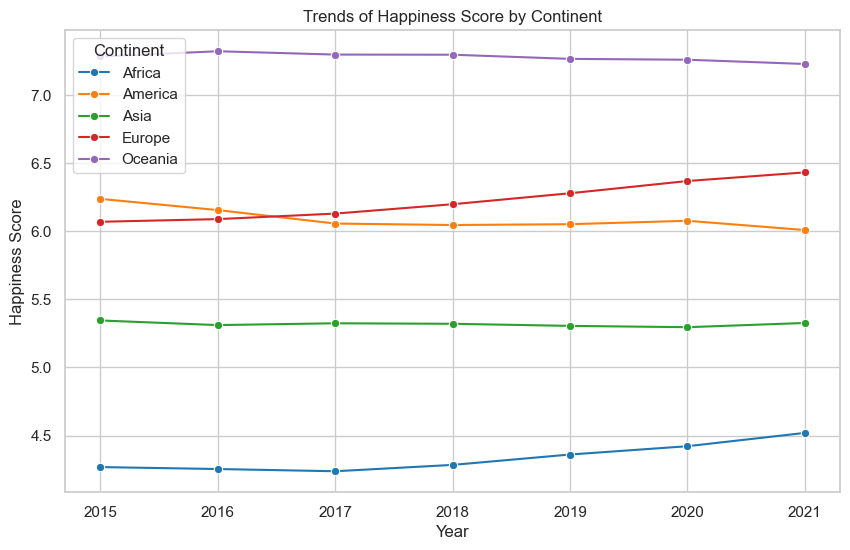

In [50]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure plots are rendered inline
%matplotlib inline

# Step 1: Average Happiness Score per Year and Continent
happiness_avg = all_data.groupby(['Year', 'Continent'])['happiness_score'].mean().reset_index()

# Step 2: Visualization
# Set the aesthetic style of the plot
sns.set_style("whitegrid")

# Initialize the plot
plt.figure(figsize=(10, 6))

# Plot Happiness Score for each continent with different colors
sns.lineplot(
    data=happiness_avg,
    x='Year',
    y='happiness_score',
    hue='Continent',
    marker='o',
    palette='tab10'
)

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Happiness Score')
plt.title('Trends of Happiness Score by Continent')

# Display the legend
plt.legend(title='Continent')

# Show the plot
plt.show()


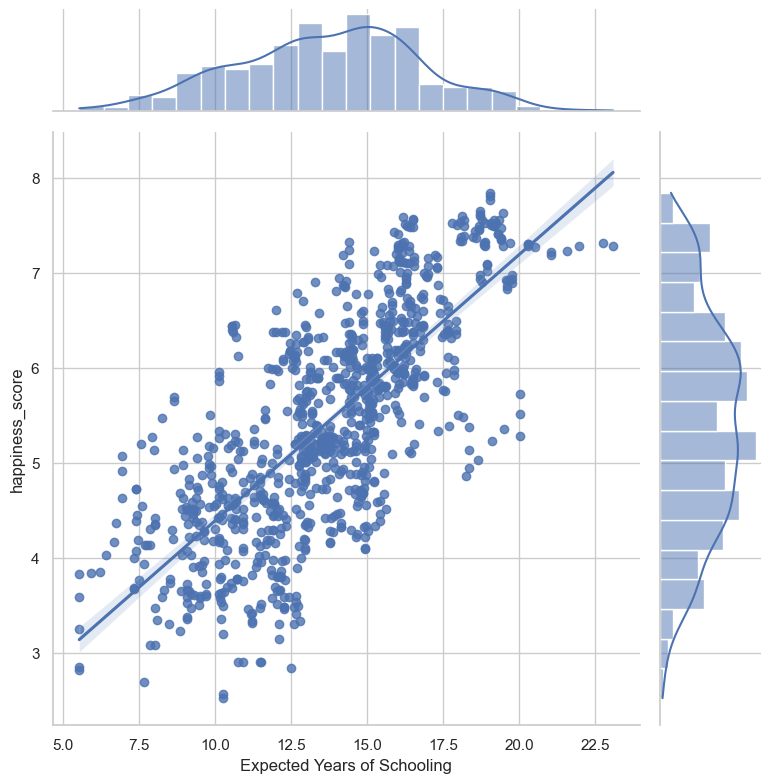

In [51]:
sns.jointplot(
    data=all_data,
    x="Expected Years of Schooling",
    y="happiness_score",
    kind="reg",
    height=8
)

In [52]:
happiness_data_year

,country,region,happiness_score,gdp_per_capita,social_support,healthy_life_expectancy,freedom_to_make_life_choices,generosity,perceptions_of_corruption,Year
0,Finland,Western Europe,7.821,1.892,1.258,0.775,0.736,0.109,0.534,2022
1,Denmark,Western Europe,7.636,1.953,1.243,0.777,0.719,0.188,0.532,2022
2,Iceland,Western Europe,7.557,1.936,1.320,0.803,0.718,0.270,0.191,2022
3,Switzerland,Western Europe,7.512,2.026,1.226,0.822,0.677,0.147,0.461,2022
4,Netherlands,Western Europe,7.415,1.945,1.206,0.787,0.651,0.271,0.419,2022
...,...,...,...,...,...,...,...,...,...,...
141,Botswana,Sub-Saharan Africa,3.471,1.503,0.815,0.280,0.571,0.012,0.102,2022
142,Rwanda,Sub-Saharan Africa,3.268,0.785,0.133,0.462,0.621,0.187,0.544,2022
143,Zimbabwe,Sub-Saharan Africa,2.995,0.947,0.690,0.270,0.329,0.106,0.105,2022
144,Lebanon,Middle East and North Africa,2.955,1.392,0.498,0.631,0.103,0.082,0.034,2022


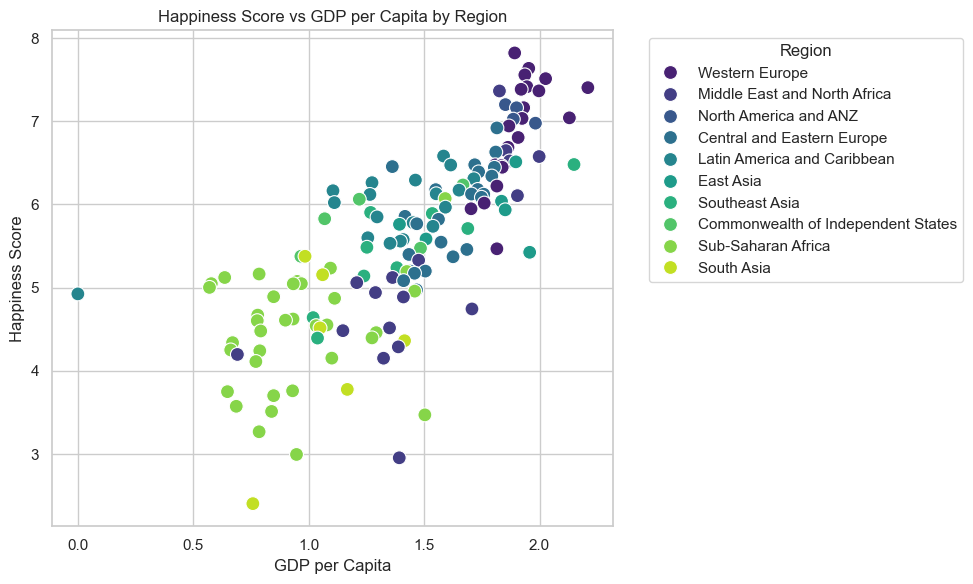

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=happiness_data_year,
    x='gdp_per_capita',               # Continuous variable on x-axis
    y='happiness_score',              # Happiness score on y-axis
    hue='region',                     # Color by region
    palette='viridis',                # Choose a color palette
    edgecolor='w',                    # Edge color for the markers
    s=100                             # Size of markers
)

# Set title and labels
plt.title('Happiness Score vs GDP per Capita by Region')
plt.xlabel('GDP per Capita')
plt.ylabel('Happiness Score')

# Display the legend outside the plot
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()


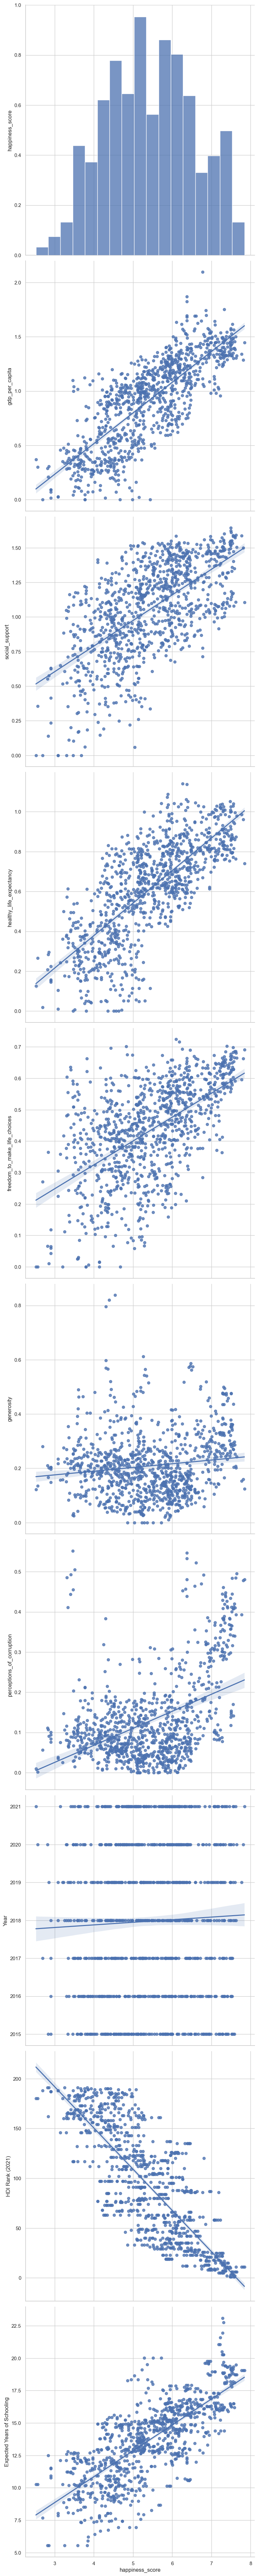

In [54]:
sns.pairplot(
    data = all_data,
    x_vars=['happiness_score'],
    # x=all_data["social_support"],
    # y=all_data["happiness_score"],
    kind="reg",
    height=8
)